# Imports and Seed Management

In [1]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import setup

env = setup.Env()

Environment loaded. Project path: /home/matti/Git/finding-tomas


In [2]:
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import fiftyone as fo
import fiftyone.utils.random as four


from src.utils import (
    seed_utils,
    visualization_utils
)


seed_utils.set_seeds(51)

/home/matti/Git/finding-tomas/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All random seeds set to 51 for reproducibility


# Dataset Creation

The existing dataset is removed if it already exists. Please be aware that any additional changes will be lost if the notebook is rerun.

In [3]:
dataset_name = "jaguar-reid-dataset"

# Remove existing dataset if it exists
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)

Load all training images from the train path while using the CSV for the ground thruth label.

In [4]:
train_csv_path = env.DATA_PATH / "jaguar-re-id" / "train.csv"
train_image_folder_path = env.DATA_PATH / "jaguar-re-id" / "train" / "train"

train_data = pd.read_csv(train_csv_path)
    
train_samples = []
for idx, row in train_data.iterrows():
    img_path = train_image_folder_path / row['filename']
    ground_truth = row['ground_truth']
    
    sample = fo.Sample(
        name=row['filename'],
        filepath=str(img_path),
        ground_truth=fo.Classification(label=ground_truth),
    )
    train_samples.append(sample)

dataset.add_samples(train_samples)
dataset.save()

 100% |███████████████| 1895/1895 [415.4ms elapsed, 0s remaining, 4.6K samples/s]   


We split the train image into train and validation. If we decide to have a fixed split we will use this split.

In [5]:
four.random_split(dataset,
                  {"train": 0.85, "validation": 0.15},
                  seed=51)

Load the test data from the test image folder without CSV.

In [6]:
test_image_folder_path = env.DATA_PATH / "jaguar-re-id" / "test" / "test"
test_image_paths = glob.glob(str(test_image_folder_path / "*.png"))

test_samples = []
for img_path in test_image_paths:
    sample = fo.Sample(
        name=img_path.split("/")[-1],
        filepath=img_path,
        ground_truth=fo.Classification(label="unknown"),
        tags=["test"]
    )
    test_samples.append(sample)

dataset.add_samples(test_samples)
dataset.save()

 100% |█████████████████| 371/371 [57.2ms elapsed, 0s remaining, 6.5K samples/s]      


In [7]:
dataset.compute_metadata()

Computing metadata...
 100% |███████████████| 2266/2266 [1.5s elapsed, 0s remaining, 1.5K samples/s]         


In [8]:
tag_counts = dataset.count_sample_tags()
print(f"Tag counts after split: {tag_counts}")

Tag counts after split: {'train': 1611, 'validation': 284, 'test': 371}


Class distribution visualization for the training and validation splits.

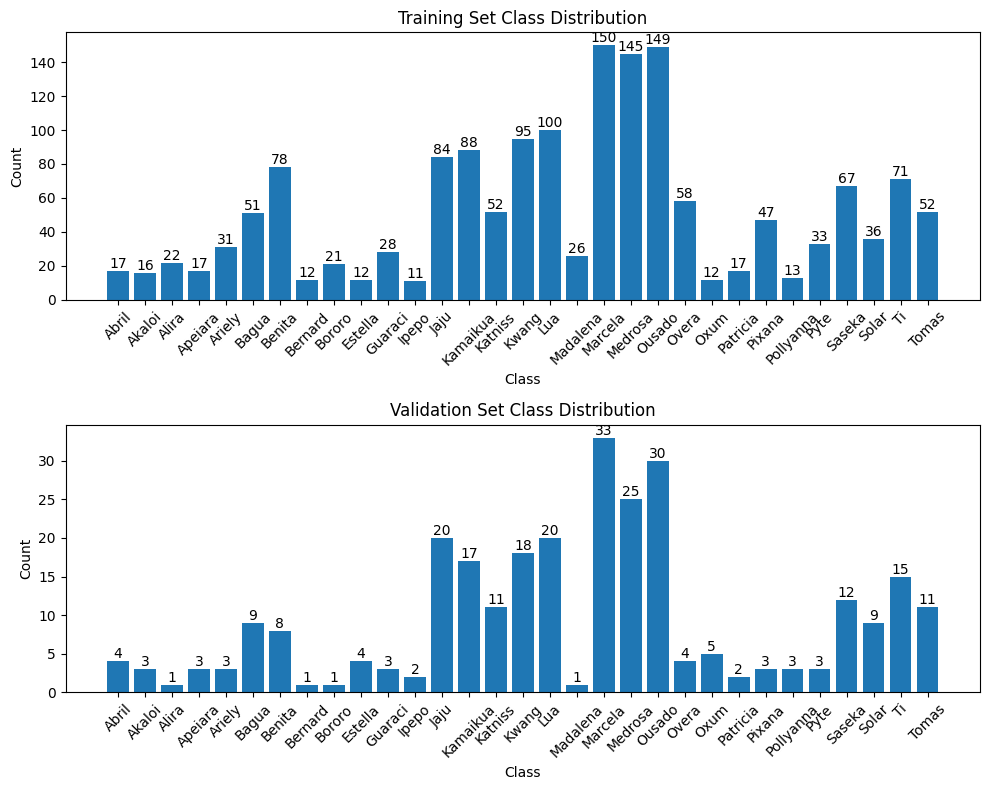

In [ ]:
train_view = dataset.match_tags("train")
val_view = dataset.match_tags("validation")

train_class_counts = train_view.count_values("ground_truth.label")

train_labels = list(train_class_counts.keys())
train_values = list(train_class_counts.values())

train_labels, train_values = zip(*sorted(zip(train_labels, train_values)))

val_class_counts = val_view.count_values("ground_truth.label")

val_labels = list(val_class_counts.keys())
val_values = list(val_class_counts.values())

val_labels, val_values = zip(*sorted(zip(val_labels, val_values)))

# Training set bar chart
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 1, 1)
visualization_utils.show_class_distribution(ax1, train_labels, train_values)

# Validation set bar chart
ax2 = plt.subplot(2, 1, 2)
visualization_utils.show_class_distribution(ax2, val_labels, val_values, is_train=False)

plt.tight_layout()
plt.show()


Launch app for visual inspection.

In [11]:
session = fo.launch_app(dataset)

# Export

Export the created dataset in FiftyOne format. We do not export the files to save memory.

In [12]:
export_dir = env.DATA_PATH / dataset_name
export_dir.mkdir(parents=True, exist_ok=True)

print(f"Exporting dataset '{dataset_name}' to: {export_dir}")

dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,  # preserves groups, modalities, metadata, labels, etc.
    overwrite=True,
    progress=True,
    export_media=False,
)

print("Export finished.")

Exporting dataset 'jaguar-reid-dataset' to: /home/matti/Git/finding-tomas/data/jaguar-reid-dataset
Exporting samples...
 100% |██████████████████| 2266/2266 [102.5ms elapsed, 0s remaining, 22.1K docs/s]    
Export finished.


We export a dictionary which tells us if an image is a train or test image to share one split over all notebooks.

In [15]:
train_imgs = []
val_imgs = []
for sample in dataset:
    if "train" in sample.tags:
        train_imgs.append(sample.name)
    elif "validation" in sample.tags:
        val_imgs.append(sample.name)

with open(env.PROJECT_PATH / "src" / "utils" / "train_val_split.pkl", "wb") as f:
    pickle.dump({"train": train_imgs, "validation": val_imgs}, f)